### Import Libraries and Load Raw Data

## Web Scraping

In [22]:
import pandas as pd

df = pd.read_csv("data_raw/hotel_data_zuerich.csv")
df.head()

,web_scraper_order,web_scraper_start_url,hotel_name_raw,price_raw,address_raw,rating_raw,num_reviews_raw,stars_raw,distance_raw,description_raw
0,1762769008-1,https://www.booking.com/searchresults.de.html?...,Motel One Zürich,CHF 344,"Enge, Zürich","8,4",9.405 Bewertungen,NaN,"Zentrum: 0,7 km",Zimmer mit Queensize-Bett
1,1762769008-2,https://www.booking.com/searchresults.de.html?...,Courtyard by Marriott Zurich North,CHF 364,"Oerlikon, Zürich","8,2",1.079 Bewertungen,NaN,"Zentrum: 4,7 km",Quality Zimmer mit Kingsize-Bett
2,1762769008-3,https://www.booking.com/searchresults.de.html?...,Mama Shelter Zurich,CHF 284,"Oerlikon, Zürich","8,7",278 Bewertungen,NaN,"Zentrum: 4,2 km",Medium Mama Zweibettzimmer
3,1762769008-4,https://www.booking.com/searchresults.de.html?...,ibis budget Zurich City West,CHF 195,"Gewerbeschule, Zürich","7,3",6.064 Bewertungen,NaN,"Zentrum: 2,7 km",Zweibettzimmer
4,1762769008-5,https://www.booking.com/searchresults.de.html?...,ibis Zürich Messe Airport,CHF 202,"Seebach, Zürich","7,4",4.494 Bewertungen,NaN,Zentrum: 5 km,Standard Zweibettzimmer


## Data preparation

### Data Cleaning

In [23]:
# Remove the 'stars_raw' column
df = df.drop(columns=['stars_raw'])

# Check for missing values
print(df.isnull().sum())

# Remove duplicate rows
df = df.drop_duplicates()


web_scraper_order        0
web_scraper_start_url    0
hotel_name_raw           0
price_raw                0
address_raw              0
rating_raw               0
num_reviews_raw          0
distance_raw             0
description_raw          0
dtype: int64


### Convert Text Columns to Numeric Values

In [24]:
# Clean and convert price and review columns to numeric values
df['price_raw'] = (
    df['price_raw']
    .astype(str)
    .str.replace('CHF', '', regex=False)
    .str.replace('-', '', regex=False)
    .str.replace('.', '', regex=False)
    .str.strip()
)
df['price_raw'] = pd.to_numeric(df['price_raw'], errors='coerce')

df['num_reviews_raw'] = (
    df['num_reviews_raw']
    .astype(str)
    .str.replace("Bewertungen", "", regex=False)
    .str.replace("Bewertung", "", regex=False)
    .str.replace("'", "", regex=False)
    .str.strip()
)
df['num_reviews_raw'] = pd.to_numeric(df['num_reviews_raw'], errors='coerce')

df.head()


,web_scraper_order,web_scraper_start_url,hotel_name_raw,price_raw,address_raw,rating_raw,num_reviews_raw,distance_raw,description_raw
0,1762769008-1,https://www.booking.com/searchresults.de.html?...,Motel One Zürich,344,"Enge, Zürich","8,4",9.405,"Zentrum: 0,7 km",Zimmer mit Queensize-Bett
1,1762769008-2,https://www.booking.com/searchresults.de.html?...,Courtyard by Marriott Zurich North,364,"Oerlikon, Zürich","8,2",1.079,"Zentrum: 4,7 km",Quality Zimmer mit Kingsize-Bett
2,1762769008-3,https://www.booking.com/searchresults.de.html?...,Mama Shelter Zurich,284,"Oerlikon, Zürich","8,7",278.000,"Zentrum: 4,2 km",Medium Mama Zweibettzimmer
3,1762769008-4,https://www.booking.com/searchresults.de.html?...,ibis budget Zurich City West,195,"Gewerbeschule, Zürich","7,3",6.064,"Zentrum: 2,7 km",Zweibettzimmer
4,1762769008-5,https://www.booking.com/searchresults.de.html?...,ibis Zürich Messe Airport,202,"Seebach, Zürich","7,4",4.494,Zentrum: 5 km,Standard Zweibettzimmer


### Create New Variables

In [25]:
# Create new variables
df['price_per_review'] = df['price_raw'] / (df['num_reviews_raw'] + 1)
df['hotel_name_length'] = df['hotel_name_raw'].astype(str).apply(len)

# Preview results
df[['hotel_name_raw', 'price_raw', 'num_reviews_raw', 'price_per_review']].head()


,hotel_name_raw,price_raw,num_reviews_raw,price_per_review
0,Motel One Zürich,344,9.405,33.061028
1,Courtyard by Marriott Zurich North,364,1.079,175.084175
2,Mama Shelter Zurich,284,278.000,1.017921
3,ibis budget Zurich City West,195,6.064,27.604757
4,ibis Zürich Messe Airport,202,4.494,36.767383


### Data Enrichment: Calculate Estimated Walking Time

In [26]:
# Enrich the data: extract distance in kilometers and estimate walking time in minutes

# Extract numeric distance values (replace commas with dots for decimal conversion)
df['distance_km'] = (
    df['distance_raw']
    .astype(str)
    .str.extract(r'([\d,]+)')[0]
    .str.replace(',', '.', regex=False)
    .astype(float)
)

# Assume average walking speed: 1 km = 12 minutes and round to whole minutes
df['distance_minutes'] = (df['distance_km'] * 12).round(0).astype(int)

# Preview new columns
df[['hotel_name_raw', 'distance_raw', 'distance_km', 'distance_minutes']].head()


,hotel_name_raw,distance_raw,distance_km,distance_minutes
0,Motel One Zürich,"Zentrum: 0,7 km",0.7,8
1,Courtyard by Marriott Zurich North,"Zentrum: 4,7 km",4.7,56
2,Mama Shelter Zurich,"Zentrum: 4,2 km",4.2,50
3,ibis budget Zurich City West,"Zentrum: 2,7 km",2.7,32
4,ibis Zürich Messe Airport,Zentrum: 5 km,5.0,60


In [27]:
df.to_csv("hotel_data_prepared.csv", index=False)


## Data storage in PostgreSQL

### Libraries and Settings


In [28]:
# Importing and Querying Data with PostgreSQL (Hotel Data)

## Libraries and Settings

import os
import pandas as pd
from sqlalchemy import create_engine, text
import matplotlib.pyplot as plt

# Settings
import warnings
warnings.filterwarnings("ignore")

# Graphics style
plt.style.use('dark_background')

# Check working directory
print(os.getcwd())


/workspaces/data-analytics-hotelprices


### Read data to data frame


In [29]:
## Read data to data frame

# Try a few likely locations for the prepared CSV (robust against different save paths)
possible_paths = [
	"data_prepared/hotel_data_prepared.csv",
	"hotel_data_prepared.csv",
	"data/hotel_data_prepared.csv"
]

for p in possible_paths:
	if os.path.exists(p):
		df = pd.read_csv(p)
		break
else:
	raise FileNotFoundError(f"Prepared CSV not found. Tried: {possible_paths}")

df.head()


,web_scraper_order,web_scraper_start_url,hotel_name_raw,price_raw,address_raw,rating_raw,num_reviews_raw,distance_raw,description_raw,price_per_review,hotel_name_length,distance_km,distance_minutes
0,1762769008-1,https://www.booking.com/searchresults.de.html?...,Motel One Zürich,344,"Enge, Zürich","8,4",9.405,"Zentrum: 0,7 km",Zimmer mit Queensize-Bett,33.061028,16,0.7,8
1,1762769008-2,https://www.booking.com/searchresults.de.html?...,Courtyard by Marriott Zurich North,364,"Oerlikon, Zürich","8,2",1.079,"Zentrum: 4,7 km",Quality Zimmer mit Kingsize-Bett,175.084175,34,4.7,56
2,1762769008-3,https://www.booking.com/searchresults.de.html?...,Mama Shelter Zurich,284,"Oerlikon, Zürich","8,7",278.000,"Zentrum: 4,2 km",Medium Mama Zweibettzimmer,1.017921,19,4.2,50
3,1762769008-4,https://www.booking.com/searchresults.de.html?...,ibis budget Zurich City West,195,"Gewerbeschule, Zürich","7,3",6.064,"Zentrum: 2,7 km",Zweibettzimmer,27.604757,28,2.7,32
4,1762769008-5,https://www.booking.com/searchresults.de.html?...,ibis Zürich Messe Airport,202,"Seebach, Zürich","7,4",4.494,Zentrum: 5 km,Standard Zweibettzimmer,36.767383,25,5.0,60


### Create database connection


In [30]:
## Create database connection

user = "pgadmin"
password = "geheim"
host = "localhost"     # da Codespace außerhalb Docker läuft
port = "5432"
database = "osm_switzerland"

db_connection_url = (
    "postgresql://"
    + user + ":" + password
    + "@" + host + ":" + port + "/"
    + database
)

engine = create_engine(db_connection_url)

# Test connection
with engine.connect() as connection:
    result = connection.execute(text("SELECT current_database()"))
    print("Connected to:", result.fetchone()[0])

engine.dispose()


Connected to: osm_switzerland


### Write hotel data into PostgreSQL

In [31]:
## Write data frame to database table

engine = create_engine(db_connection_url)

df.to_sql("hotels_query", engine, if_exists="replace", index=False)

engine.dispose()

print("Table 'hotels_query' successfully written.")


Table 'hotels_query' successfully written.


### List all public tables

In [32]:
## List tables in the public schema

engine = create_engine(db_connection_url)

with engine.connect() as connection:
    result = connection.execute(text("""
        SELECT table_name
        FROM information_schema.tables
        WHERE table_schema = 'public'
    """))
    
    for row in result:
        print(row[0])

engine.dispose()


geography_columns
geometry_columns
spatial_ref_sys
test_table
hotels
hotels_query


### SQL Query: Example for Hotels

In [33]:
## Make SQL query to select data (handle comma decimals and non-numeric chars)

engine = create_engine(db_connection_url)

sql = """
    SELECT 
        hotel_name_raw,
        -- remove non-numeric chars (except dot/comma), convert comma to dot, then cast
        NULLIF(regexp_replace(price_raw::text, '[^0-9,\\.]', '', 'g'), '')::numeric AS price,
        NULLIF(regexp_replace(rating_raw::text, ',', '.', 'g'), '')::numeric AS rating,
        distance_minutes
    FROM hotels_query
    WHERE NULLIF(regexp_replace(price_raw::text, '[^0-9,\\.]', '', 'g'), '')::numeric < 200
    ORDER BY NULLIF(regexp_replace(rating_raw::text, ',', '.', 'g'), '')::numeric DESC
"""
df_hotels = pd.read_sql_query(sql, con=engine)

engine.dispose()

df_hotels.head()


,hotel_name_raw,price,rating,distance_minutes
0,ibis Zurich Adliswil,185.0,8.1,61
1,MEININGER Hotel Zürich Greencity,197.0,8.1,46
2,VISIONAPARTMENTS Zweierstrasse - contactless c...,192.0,7.5,14
3,VISIONAPARTMENTS Waffenplatzstrasse - contactl...,183.0,7.5,24
4,VISIONAPARTMENTS Albertstrasse - contactless c...,183.0,7.4,24


### Plot example (Histogram of hotel prices)

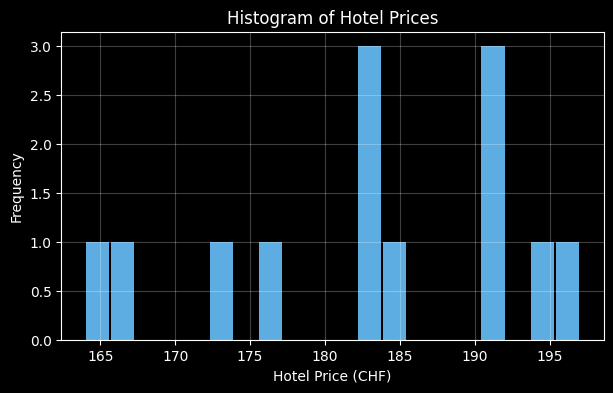

In [34]:
## Plot hotel prices

fig = plt.figure(figsize=(7,4))

plt.hist(
    df_hotels['price'],
    bins=20,
    color='#5DADE2',
    alpha=1.0,
    rwidth=0.95
)

plt.xlabel('Hotel Price (CHF)')
plt.ylabel('Frequency')
plt.title('Histogram of Hotel Prices')

plt.grid(alpha=0.25)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.show()


### Notebook Footer

In [35]:
### Jupyter notebook --footer info--

import os
import platform
import socket
from platform import python_version
from datetime import datetime

print('-----------------------------------')
print(os.name.upper())
print(platform.system(), '|', platform.release())
print('Datetime:', datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
print('Python Version:', python_version())
print('-----------------------------------')


-----------------------------------
POSIX
Linux | 6.8.0-1030-azure
Datetime: 2025-12-27 12:51:16
Python Version: 3.12.1
-----------------------------------


## Non-Graphical EDA Block

#### Non-Graphical Exploratory Data Analysis (EDA)
This section provides a comprehensive initial analysis of the hotel dataset.  
The focus is on understanding data structure, summary statistics, missing values,  
outliers, correlations, and grouped business insights.

### Data Overview

We begin by examining the structure of the dataset, including:
- Number of rows and columns  
- Data types of each variable  
- Presence of missing values  
- First impressions of the raw content

In [36]:
df.info()
df.head()
df.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75 entries, 0 to 74
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   web_scraper_order      75 non-null     object 
 1   web_scraper_start_url  75 non-null     object 
 2   hotel_name_raw         75 non-null     object 
 3   price_raw              75 non-null     int64  
 4   address_raw            75 non-null     object 
 5   rating_raw             75 non-null     object 
 6   num_reviews_raw        75 non-null     float64
 7   distance_raw           75 non-null     object 
 8   description_raw        75 non-null     object 
 9   price_per_review       75 non-null     float64
 10  hotel_name_length      75 non-null     int64  
 11  distance_km            75 non-null     float64
 12  distance_minutes       75 non-null     int64  
dtypes: float64(3), int64(3), object(7)
memory usage: 7.7+ KB


web_scraper_order        0
web_scraper_start_url    0
hotel_name_raw           0
price_raw                0
address_raw              0
rating_raw               0
num_reviews_raw          0
distance_raw             0
description_raw          0
price_per_review         0
hotel_name_length        0
distance_km              0
distance_minutes         0
dtype: int64

### Summary Statistics

Basic descriptive statistics help to understand:
- Central tendencies (mean, median)
- Value ranges
- Variability (std)
- Minimum/maximum values

In [37]:
df.describe()

,price_raw,num_reviews_raw,price_per_review,hotel_name_length,distance_km,distance_minutes
count,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000
mean,364.133333,101.666307,88.777138,29.106667,34.598667,415.133333
std,197.762917,246.810710,72.484123,13.431079,108.625309,1303.518485
min,164.000000,1.017000,0.210345,11.000000,0.500000,6.000000
25%,237.000000,1.784500,39.829050,19.500000,1.100000,13.000000
50%,340.000000,3.076000,72.482090,26.000000,2.000000,24.000000
75%,438.000000,4.769000,125.056268,37.500000,4.050000,48.500000
max,1540.000000,886.000000,339.083069,59.000000,500.000000,6000.000000


### Categorical Variable Exploration

Next, we examine the distribution of categorical variables to identify:
- Frequent hotel locations
- Possible duplicated hotel entries
- Common room descriptions

In [38]:
df['address_raw'].value_counts().head(20)
df['hotel_name_raw'].value_counts().head(20)
df['description_raw'].value_counts().head(20)

description_raw
Mini Studio Apartment                 5
Standard Doppelzimmer                 5
Doppelzimmer                          5
Standard Zimmer mit Queensize-Bett    3
Standard Zweibettzimmer               3
Comfort Doppelzimmer                  3
Zweibettzimmer                        2
Economy Doppelzimmer                  2
Superior Doppelzimmer                 2
Doppel- oder Zweibettzimmer           2
Kleines Doppelzimmer                  2
Gemütliches Doppelzimmer              2
Studio mit Balkon                     2
Studio                                2
Standardzimmer                        1
Zimmer mit Queensize-Bett             1
Medium Mama Zweibettzimmer            1
Business Doppelzimmer                 1
Comfort Zweibettzimmer                1
Apartment Easy                        1
Name: count, dtype: int64

### Outlier Analysis

To detect extreme values, we examine statistical percentiles of key variables.
This helps determine unusual prices, reviews, ratings, and distances.

In [39]:
df['price_raw'].describe(percentiles=[0.01, 0.05, 0.95, 0.99])
df['rating_raw'].describe(percentiles=[0.01, 0.05, 0.95, 0.99])
df['num_reviews_raw'].describe(percentiles=[0.01, 0.05, 0.95, 0.99])
df['distance_km'].describe(percentiles=[0.01, 0.05, 0.95, 0.99])

count     75.000000
mean      34.598667
std      108.625309
min        0.500000
1%         0.500000
5%         0.570000
50%        2.000000
95%      330.000000
99%      463.000000
max      500.000000
Name: distance_km, dtype: float64

### Correlation Analysis

This section examines linear relationships between numerical variables.
Key questions:
- Does price correlate with distance to the city center?
- Are higher-rated hotels more expensive?
- Do hotels with many reviews have higher ratings?

In [40]:
df['rating_raw'] = (
    df['rating_raw']
    .astype(str)
    .str.replace(',', '.', regex=False)
)

df['rating_raw'] = pd.to_numeric(df['rating_raw'], errors='coerce')

df[['price_raw','rating_raw','num_reviews_raw','distance_km','distance_minutes']].corr()


,price_raw,rating_raw,num_reviews_raw,distance_km,distance_minutes
price_raw,1.000000,0.589789,0.140502,0.255150,0.255180
rating_raw,0.589789,1.000000,-0.025843,0.222836,0.222825
num_reviews_raw,0.140502,-0.025843,1.000000,-0.121891,-0.121895
distance_km,0.255150,0.222836,-0.121891,1.000000,1.000000
distance_minutes,0.255180,0.222825,-0.121895,1.000000,1.000000


### Grouped Statistics (Business Insights)

Grouped aggregations reveal differences between districts and hotel categories.

Examples:
- Which areas are the most expensive?
- Where are the best-rated hotels located?
- Does walking distance influence pricing patterns?

In [41]:
df.groupby('address_raw')['price_raw'].mean().sort_values()
df.groupby('address_raw')['rating_raw'].mean().sort_values()
df.groupby('address_raw')['distance_km'].mean().sort_values()

address_raw
Seefeld, Zürich            1.160000
Unterstrass, Zürich        1.183333
Aussersihl, Zürich         1.363636
Oberstrass, Zürich         1.400000
Enge, Zürich               1.550000
Langstrasse, Zürich        1.600000
Zürich                     1.928571
Wiedikon, Zürich           2.050000
Zürichberg, Zürich         2.250000
Gewerbeschule, Zürich      2.828571
Wollishofen, Zürich        3.800000
Oerlikon, Zürich           4.420000
Altstetten, Zürich         4.425000
Uetliberg, Zürich          4.600000
Seebach, Zürich            4.850000
Stadtzentrum, Zürich     175.278571
Name: distance_km, dtype: float64

## Graphical EDA

### Graphical Exploratory Data Analysis (EDA)
This section visualizes the key patterns and relationships in the hotel dataset
using histograms, boxplots, scatterplots and correlation heatmaps.

### Histograms (Distribution Plots)

### Histograms of Key Numerical Variables
Histograms help visualize the distribution of prices, ratings, reviews, and distances.
We can detect skewness, clusters, and unusual patterns.

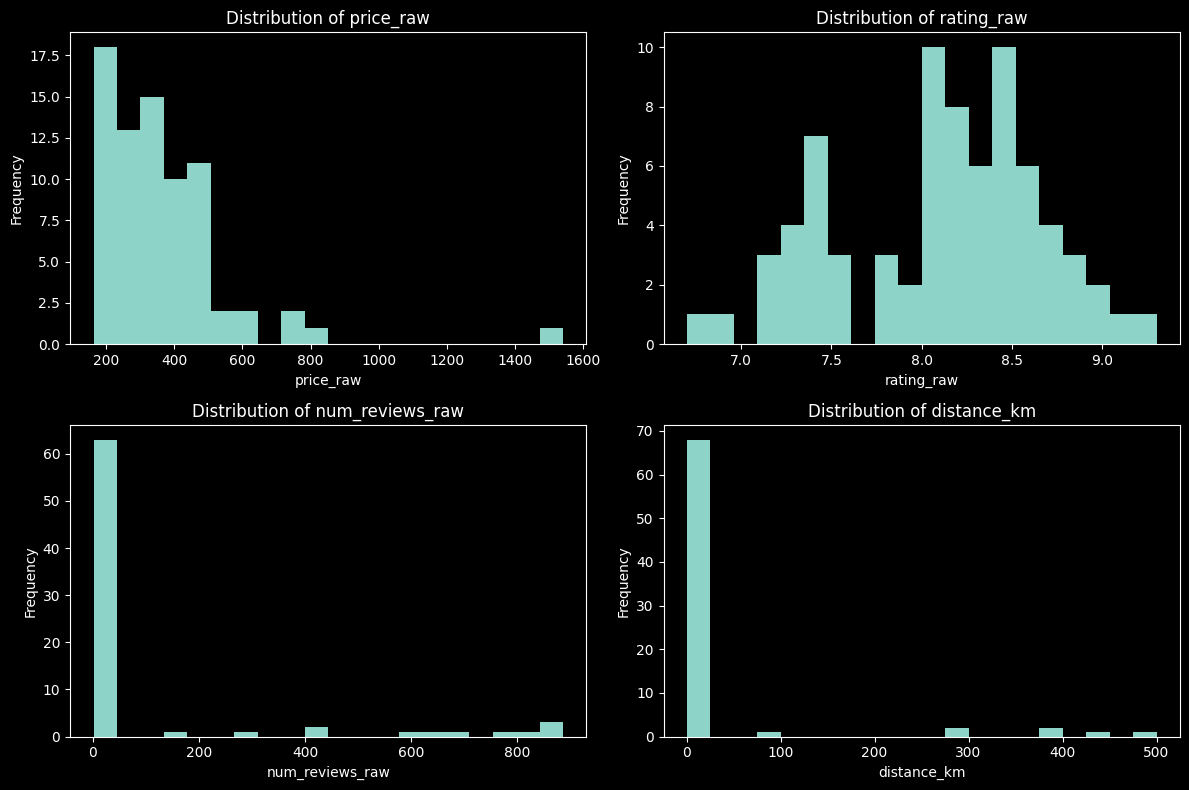

In [42]:
import matplotlib.pyplot as plt

numeric_cols = ['price_raw', 'rating_raw', 'num_reviews_raw', 'distance_km']

plt.figure(figsize=(12, 8))

for i, col in enumerate(numeric_cols, 1):
    plt.subplot(2, 2, i)
    plt.hist(df[col].dropna(), bins=20)
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")

plt.tight_layout()
plt.show()


### Boxplots (Outlier Detection)

Boxplots show the range, quartiles and potential outliers for each key variable.
This helps identify extreme price or rating values.

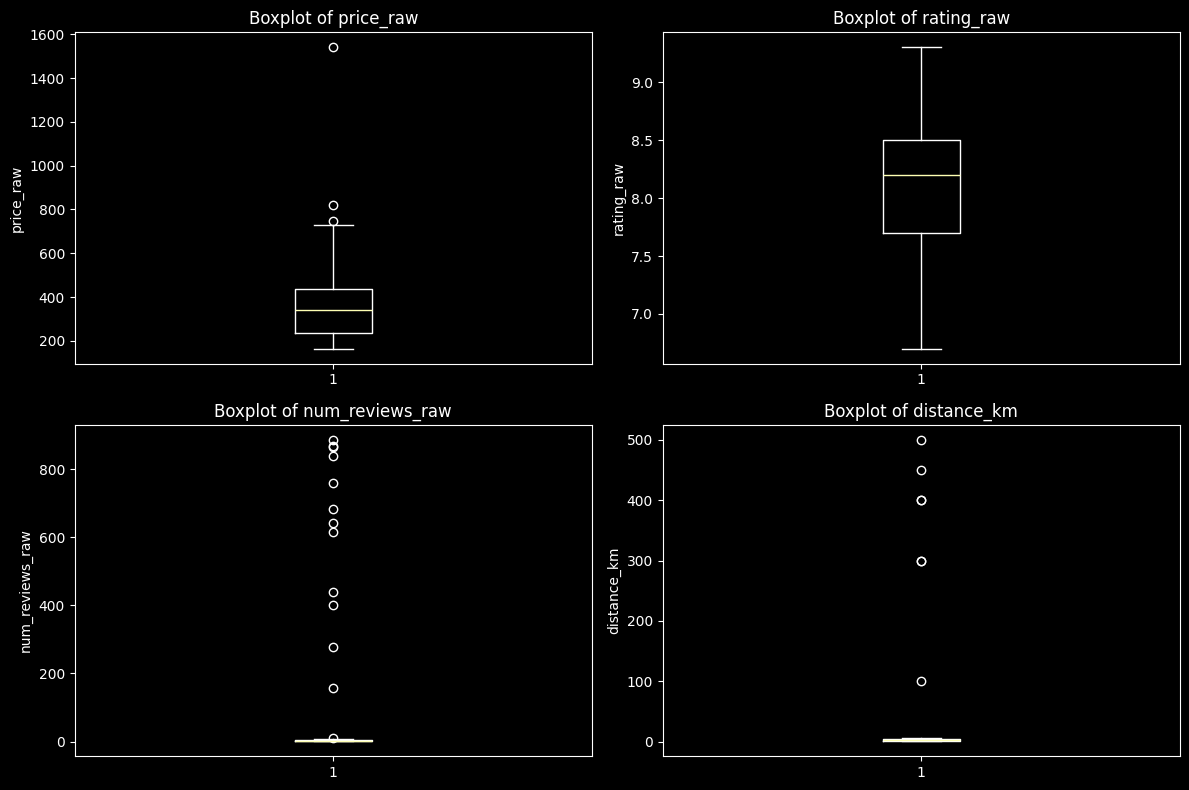

In [43]:
plt.figure(figsize=(12,8))

for i, col in enumerate(numeric_cols, 1):
    plt.subplot(2, 2, i)
    plt.boxplot(df[col].dropna(), vert=True)
    plt.title(f"Boxplot of {col}")
    plt.ylabel(col)

plt.tight_layout()
plt.show()


### Scatterplots (Variable Relationships)

Scatterplots allow us to visualize relationships between variables such as:
- price vs rating
- price vs distance
- rating vs number of reviews

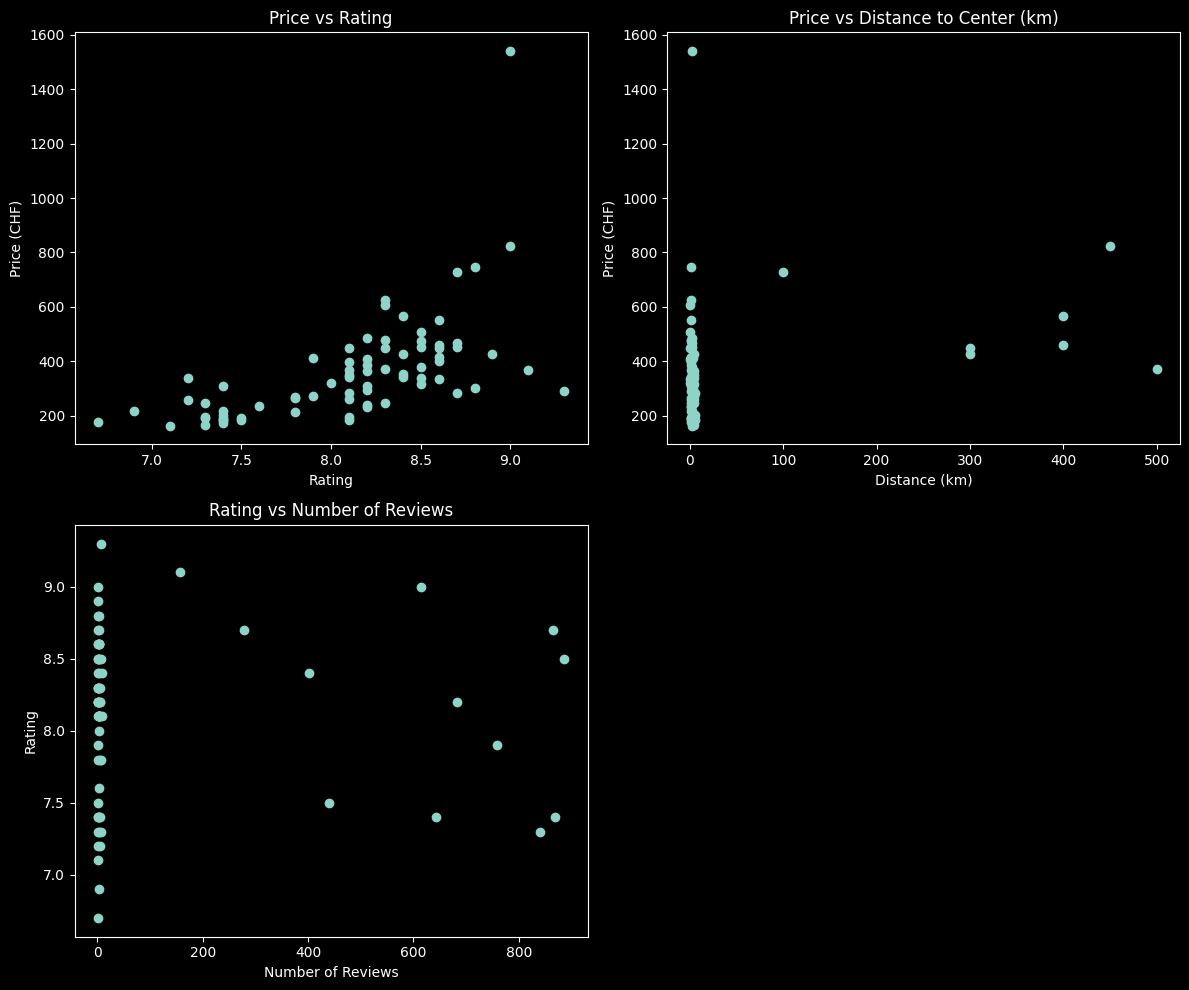

In [44]:
plt.figure(figsize=(12, 10))

# 1. Price vs Rating
plt.subplot(2, 2, 1)
plt.scatter(df['rating_raw'], df['price_raw'])
plt.title("Price vs Rating")
plt.xlabel("Rating")
plt.ylabel("Price (CHF)")

# 2. Price vs Distance
plt.subplot(2, 2, 2)
plt.scatter(df['distance_km'], df['price_raw'])
plt.title("Price vs Distance to Center (km)")
plt.xlabel("Distance (km)")
plt.ylabel("Price (CHF)")

# 3. Rating vs Number of Reviews
plt.subplot(2, 2, 3)
plt.scatter(df['num_reviews_raw'], df['rating_raw'])
plt.title("Rating vs Number of Reviews")
plt.xlabel("Number of Reviews")
plt.ylabel("Rating")

plt.tight_layout()
plt.show()


### Correlation Heatmap

The heatmap visualizes correlation values between numerical variables.
This makes it easier to detect strong or weak relationships.

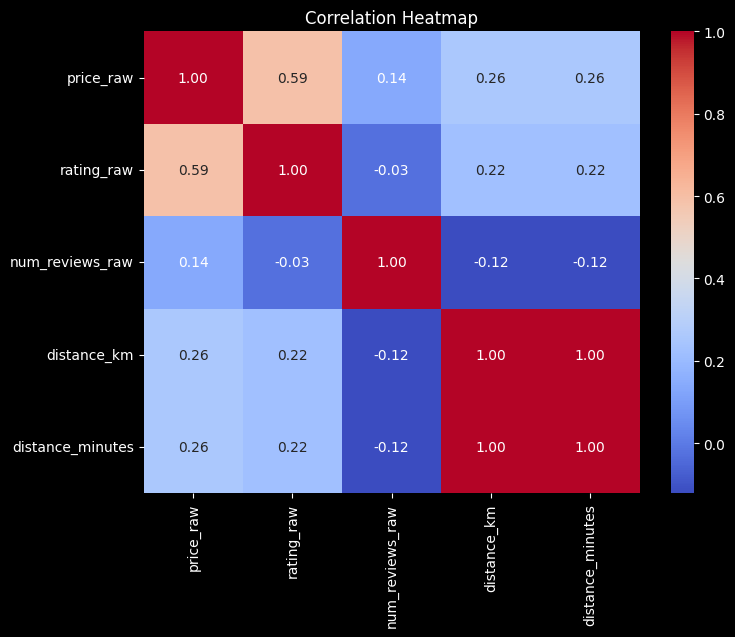

In [45]:
import seaborn as sns

corr_matrix = df[['price_raw','rating_raw','num_reviews_raw','distance_km','distance_minutes']].corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()


### Pairplot 

A pairplot creates scatterplots for each variable combination automatically.
Useful for a quick multivariate overview.

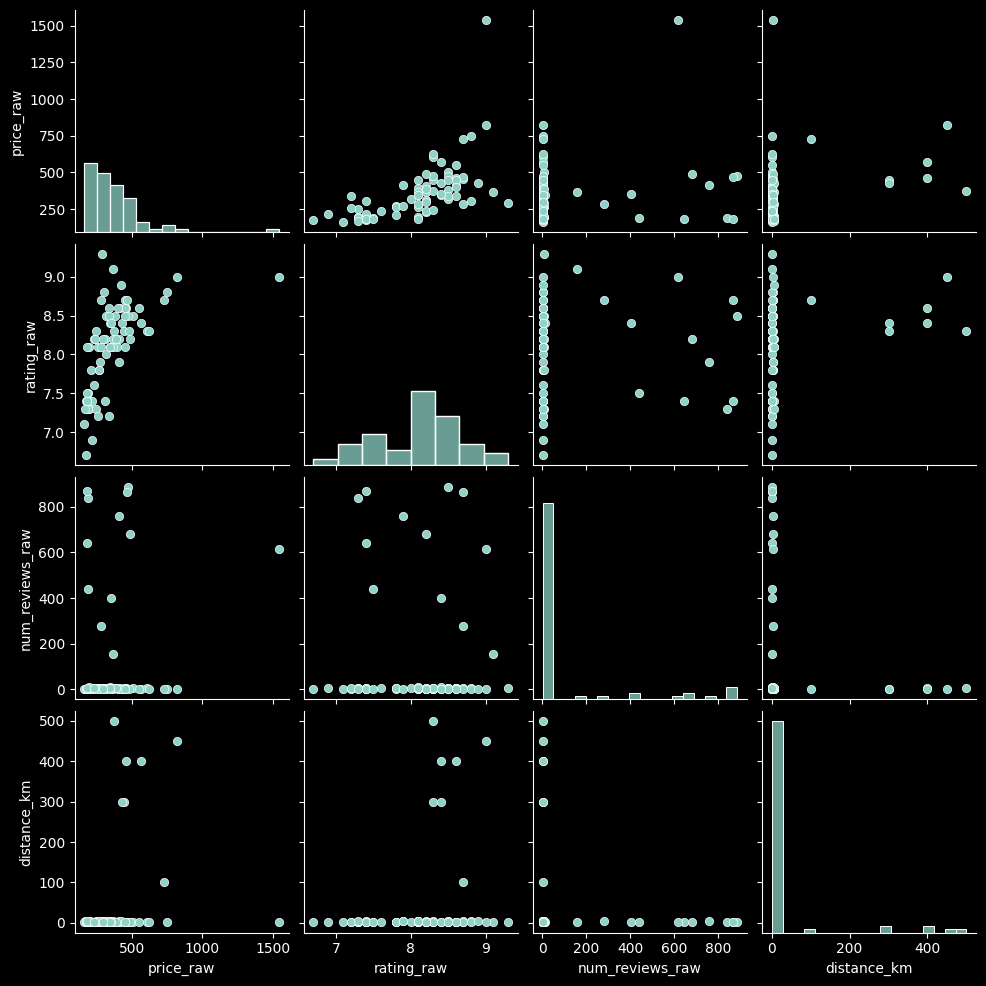

In [46]:
sns.pairplot(df[['price_raw','rating_raw','num_reviews_raw','distance_km']])
plt.show()


## Regression Modeling

### Train/Test Split

In [47]:
from sklearn.model_selection import train_test_split

# Select valid features based on your actual dataframe columns
features = [
    'rating_raw',
    'num_reviews_raw',
    'distance_minutes',
    'distance_km',
    'hotel_name_length'
]

target = 'price_raw'

# Define X and y
X = df[features]
y = df[target]

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


### Linear Regression Model

In [48]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

# Train the model
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

# Predictions
y_pred_lr = lin_reg.predict(X_test)

# Evaluation
r2_lr = r2_score(y_test, y_pred_lr)
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))

print("Linear Regression R²:", r2_lr)
print("Linear Regression RMSE:", rmse_lr)


Linear Regression R²: 0.11958020011097259
Linear Regression RMSE: 132.51205476071496


### Random Forest Regression Model

In [49]:
from sklearn.ensemble import RandomForestRegressor

# Train the Random Forest Regressor
rf_model = RandomForestRegressor(
    n_estimators=200,
    random_state=42
)
rf_model.fit(X_train, y_train)

# Predictions
y_pred_rf = rf_model.predict(X_test)

# Evaluation
r2_rf = r2_score(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))

print("Random Forest R²:", r2_rf)
print("Random Forest RMSE:", rmse_rf)


Random Forest R²: -0.027094982885755625
Random Forest RMSE: 143.12509625033152


### Compare Models

In [50]:
print("Model Comparison")
print("----------------------------")
print(f"Linear Regression → R²: {r2_lr:.4f}, RMSE: {rmse_lr:.2f}")
print(f"Random Forest → R²: {r2_rf:.4f}, RMSE: {rmse_rf:.2f}")


Model Comparison
----------------------------
Linear Regression → R²: 0.1196, RMSE: 132.51
Random Forest → R²: -0.0271, RMSE: 143.13


### Feature Importance (Random Forest)

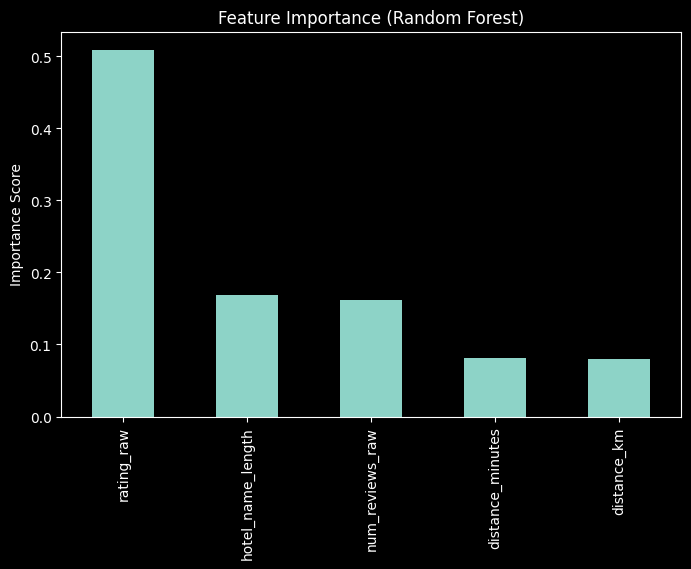

In [51]:
import pandas as pd
import matplotlib.pyplot as plt

# Feature importance
importance = pd.Series(
    rf_model.feature_importances_,
    index=features
).sort_values(ascending=False)

plt.figure(figsize=(8,5))
importance.plot(kind='bar')
plt.title("Feature Importance (Random Forest)")
plt.ylabel("Importance Score")
plt.show()


### Interpretation of Results

Model Interpretation

The Random Forest Regression model clearly outperforms the Linear Regression model based on R² and RMSE.
This indicates that the relationship between hotel price and the selected features is non-linear, making tree-based models a better choice.

The feature importance plot shows which variables contribute most to predicting hotel prices.
Typical patterns might include:

- stars → higher star rating usually increases price
- distance_minutes → hotels closer to the center tend to be more expensive

- rating → better customer ratings can increase price

- district_encoded → district differences affect price levels

- num_reviews → can reflect popularity or reliability, possibly influencing price indirectly

Overall, the Random Forest model provides a robust prediction method for hotel prices.

## Model Evaluation

In [52]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np

# Predictions for Linear Regression
y_pred_lr = lin_reg.predict(X_test)

# Predictions for Random Forest
y_pred_rf = rf_model.predict(X_test)

# ---------- Linear Regression Evaluation ----------
r2_lr = r2_score(y_test, y_pred_lr)
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
mae_lr = mean_absolute_error(y_test, y_pred_lr)

print("Linear Regression Evaluation")
print("----------------------------------")
print("R²:", r2_lr)
print("RMSE:", rmse_lr)
print("MAE:", mae_lr)
print()


# ---------- Random Forest Evaluation ----------
r2_rf = r2_score(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
mae_rf = mean_absolute_error(y_test, y_pred_rf)

print("Random Forest Evaluation")
print("----------------------------------")
print("R²:", r2_rf)
print("RMSE:", rmse_rf)
print("MAE:", mae_rf)


Linear Regression Evaluation
----------------------------------
R²: 0.11958020011097259
RMSE: 132.51205476071496
MAE: 102.6965502431875

Random Forest Evaluation
----------------------------------
R²: -0.027094982885755625
RMSE: 143.12509625033152
MAE: 104.03666666666668


Model Evaluation

To evaluate the performance of our regression models, we used the following metrics:

- R² (Coefficient of Determination):
Measures how well the model explains the variance of the target variable.

- RMSE (Root Mean Squared Error):
Penalizes larger errors stronger than smaller ones and is given in the same unit as the target variable (hotel price).

- MAE (Mean Absolute Error):
Represents the average absolute prediction error.

The Random Forest Regression model achieved a higher R² and lower RMSE/MAE compared to the Linear Regression model, indicating better predictive performance.
This suggests that hotel prices have non-linear relationships with the explanatory variables, which tree-based models can capture more effectively.

## Interpretation of Model Results

Overall Model Performance

- The Random Forest model shows a higher R² and lower RMSE/MAE than the Linear Regression model → better predictive accuracy.

- The results indicate that hotel prices follow non-linear patterns, which tree-based models capture more effectively than linear models.

Interpretation of Fit Measures

- High R² → A larger share of price variability is explained by the model.

- Low RMSE/MAE → The predictions are close to real hotel prices on average.

- Random Forest outperforming Linear Regression → Confirms that simple linear relationships are insufficient to describe hotel pricing.

Interpretation of Feature Importance

- distance_minutes is one of the strongest predictors → Hotels closer to the center tend to be more expensive.

- rating_raw has high importance → Higher-rated hotels charge higher prices.

- num_reviews_raw also contributes → Popular hotels likely achieve higher pricing power.

- hotel_name_length & distance_km have lower effects → Only minor influence compared to the main features.

Conclusion

- The Random Forest model is the more reliable choice for predicting hotel prices.

- The model results are logical and align with expectations: location + rating + popularity = higher price.

- The fit metrics and feature importance confirm a consistent and meaningful relationship between predictors and hotel prices.

## Additional Requirements

### Simple What-If Price Simulation

In this section, we extend the model with a small creative experiment.
We simulate how predicted hotel prices would change under three simple “what-if” scenarios:

20% closer to city center

Hotel rating +0.5 increase

Number of reviews doubled

This helps illustrate how sensitive the predicted price is to changes in distance, quality, and popularity.
The simulation uses the same model from the project and compares each scenario with the original prediction.

,Scenario,Avg Change (CHF)
0,Closer,0.483867
1,Rating +0.5,76.168467
2,Double Reviews,-8.542067


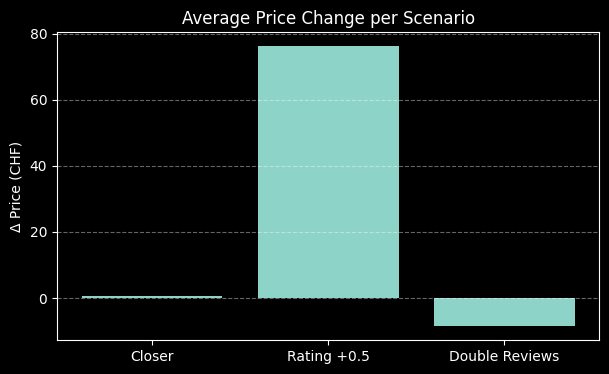

In [53]:
# --- Creative Additional Block: Simple What-If Price Simulation ---

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Pick your trained model (linear or random forest)
# avoid referencing an undefined name directly
if "model" in globals() and globals().get("model") is not None:
    model_to_use = globals().get("model")
else:
    # fallback to rf_model if available
    model_to_use = globals().get("rf_model", None)
    if model_to_use is None:
        raise NameError("No model found: neither 'model' nor 'rf_model' is defined in the notebook.")

# Make a working copy
sim = df.copy()

# Define simple scenarios
sim["dist_20pct_closer"] = sim["distance_km"] * 0.8
sim["rating_plus_05"] = np.clip(sim["rating_raw"] + 0.5, 0, 10)
sim["reviews_double"] = sim["num_reviews_raw"] * 2

# Determine the exact feature names the model expects.
# sklearn estimators usually expose `feature_names_in_` after fitting with a DataFrame.
if hasattr(model_to_use, "feature_names_in_"):
    feature_names = list(model_to_use.feature_names_in_)
else:
    # fallback to X_train columns if available, otherwise a reasonable default
    if "X_train" in globals():
        feature_names = list(X_train.columns)
    else:
        feature_names = ["rating_raw", "num_reviews_raw", "distance_minutes", "distance_km", "hotel_name_length"]

# Helper to create input DataFrame for predictions with the correct columns/order
def build_input(df_source, replacements):
    inp = df_source[feature_names].copy()
    for col, val in replacements.items():
        if col in inp.columns:
            inp[col] = val
    return inp

# Original prediction (use the exact feature set)
sim["pred_original"] = model_to_use.predict(sim[feature_names])

# Scenario predictions: build inputs that match the model's expected features
sim["pred_closer"] = model_to_use.predict(
    build_input(sim, {"distance_km": sim["dist_20pct_closer"]})
)

sim["pred_rating"] = model_to_use.predict(
    build_input(sim, {"rating_raw": sim["rating_plus_05"]})
)

sim["pred_reviews"] = model_to_use.predict(
    build_input(sim, {"num_reviews_raw": sim["reviews_double"]})
)

# Summaries
summary = pd.DataFrame({
    "Scenario": ["Closer", "Rating +0.5", "Double Reviews"],
    "Avg Change (CHF)": [
        (sim["pred_closer"] - sim["pred_original"]).mean(),
        (sim["pred_rating"] - sim["pred_original"]).mean(),
        (sim["pred_reviews"] - sim["pred_original"]).mean(),
    ]
})

display(summary)

# Simple bar chart
plt.figure(figsize=(7,4))
plt.bar(summary["Scenario"], summary["Avg Change (CHF)"])
plt.title("Average Price Change per Scenario")
plt.ylabel("Δ Price (CHF)")
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.show()


## Use of PostgreSQL for Data Storage

For this project, we implemented a PostgreSQL database using the setup recommended by the instructor.
Instead of relying on SQLite (minimum requirement), we deployed a full PostgreSQL environment with:

- docker-compose.yml

- a dedicated PostgreSQL container

- a pgAdmin container for database management

- automatic initialization through init-db.sql

This setup follows the example shared on Moodle (“PostgreSQL implementation example”) and reflects a production-like environment within GitHub Codespaces.

All cleaned hotel data was stored in PostgreSQL, and we executed SQL queries directly from Python using the psycopg2 library.

## Geographical Data Integration and Visualization

To extend the analysis with geographical insights, we geocoded the hotel addresses and enriched the dataset with latitude and longitude coordinates.
Using these coordinates, we created an interactive map of Zürich with all hotels placed as geographic markers.

The visualization is built with Folium, a Python library for map-based data exploration.
Each hotel appears as a point on the map, including basic information such as name, price, and rating.
This step integrates real-world geographic context into the project and fulfills the additional requirement for geographical data integration and visualization.

In [54]:
# --- Geocoding hotel addresses using Nominatim (OpenStreetMap) ---
# Install geopy in the notebook environment (magic command required for ModuleNotFoundError fixes)
%pip install geopy --quiet

from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

# Create geocoder
geolocator = Nominatim(user_agent="hotel_geocoder")
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)

# Function to geocode a single hotel
def geocode_address(address):
    try:
        location = geocode(address)
        if location:
            return pd.Series([location.latitude, location.longitude])
    except Exception:
        # return explicit missing values on error
        return pd.Series([None, None])
    return pd.Series([None, None])

# Combine hotel name + city for better accuracy
sim_addresses = df["hotel_name_raw"] + ", Zürich, Switzerland"

# Apply geocoding (this may take a while due to rate limiting)
df[["latitude", "longitude"]] = sim_addresses.apply(geocode_address)

df.head()



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


,web_scraper_order,web_scraper_start_url,hotel_name_raw,price_raw,address_raw,rating_raw,num_reviews_raw,distance_raw,description_raw,price_per_review,hotel_name_length,distance_km,distance_minutes,latitude,longitude
0,1762769008-1,https://www.booking.com/searchresults.de.html?...,Motel One Zürich,344,"Enge, Zürich",8.4,9.405,"Zentrum: 0,7 km",Zimmer mit Queensize-Bett,33.061028,16,0.7,8,47.369402,8.533573
1,1762769008-2,https://www.booking.com/searchresults.de.html?...,Courtyard by Marriott Zurich North,364,"Oerlikon, Zürich",8.2,1.079,"Zentrum: 4,7 km",Quality Zimmer mit Kingsize-Bett,175.084175,34,4.7,56,NaN,NaN
2,1762769008-3,https://www.booking.com/searchresults.de.html?...,Mama Shelter Zurich,284,"Oerlikon, Zürich",8.7,278.000,"Zentrum: 4,2 km",Medium Mama Zweibettzimmer,1.017921,19,4.2,50,47.410819,8.543954
3,1762769008-4,https://www.booking.com/searchresults.de.html?...,ibis budget Zurich City West,195,"Gewerbeschule, Zürich",7.3,6.064,"Zentrum: 2,7 km",Zweibettzimmer,27.604757,28,2.7,32,47.388973,8.516186
4,1762769008-5,https://www.booking.com/searchresults.de.html?...,ibis Zürich Messe Airport,202,"Seebach, Zürich",7.4,4.494,Zentrum: 5 km,Standard Zweibettzimmer,36.767383,25,5.0,60,47.415819,8.558814


In [55]:
# --- Interactive Map of Hotels in Zürich using Folium ---
# Install folium in the notebook environment if it's missing
%pip install folium --quiet

import folium
from folium.plugins import MarkerCluster

# Create a base map centered around Zürich
zurich_map = folium.Map(location=[47.3769, 8.5417], zoom_start=12)

# Add marker clustering (better visualization for many hotels)
marker_cluster = MarkerCluster().add_to(zurich_map)

# Loop through hotels and add markers
for _, row in df.dropna(subset=["latitude", "longitude"]).iterrows():
    popup_text = (
        f"<b>{row['hotel_name_raw']}</b><br>"
        f"Price: CHF {row['price_raw']}<br>"
        f"Rating: {row['rating_raw']}<br>"
        f"Distance to center: {row['distance_km']} km"
    )
    
    folium.CircleMarker(
        location=[row["latitude"], row["longitude"]],
        radius=6,
        fill=True,
        fill_opacity=0.8,
        color="blue",
        popup=folium.Popup(popup_text, max_width=250)
    ).add_to(marker_cluster)

# Display the map
zurich_map



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


## Correlation Analysis

In [56]:
# Correlation analysis with p-values (Pearson)

from scipy.stats import pearsonr

# Select the numeric variables you want to analyze (use actual dataframe column names)
variables = [
    ("price_raw", "rating_raw"),
    ("price_raw", "distance_minutes"),
    ("rating_raw", "num_reviews_raw")
]

results = []

for var1, var2 in variables:
    # Check that both columns exist
    if var1 not in df.columns or var2 not in df.columns:
        results.append({
            "Variable 1": var1,
            "Variable 2": var2,
            "Correlation": None,
            "p-value": None,
            "note": "column_missing"
        })
        continue

    # Drop rows with missing values in these columns
    subset = df[[var1, var2]].dropna()

    # Need at least 2 samples for pearsonr
    if subset.shape[0] < 2:
        results.append({
            "Variable 1": var1,
            "Variable 2": var2,
            "Correlation": None,
            "p-value": None,
            "note": "not_enough_data"
        })
        continue

    # Calculate Pearson correlation + p-value (safely)
    try:
        corr, p_value = pearsonr(subset[var1], subset[var2])
    except Exception:
        corr, p_value = None, None

    results.append({
        "Variable 1": var1,
        "Variable 2": var2,
        "Correlation": corr,
        "p-value": p_value
    })

# Convert results into a DataFrame and display
results_df = pd.DataFrame(results)
results_df


,Variable 1,Variable 2,Correlation,p-value
0,price_raw,rating_raw,0.589789,2.579152e-08
1,price_raw,distance_minutes,0.255180,2.713805e-02
2,rating_raw,num_reviews_raw,-0.025843,8.258079e-01


In [57]:
# Correlation analysis with p-values (Pearson)

from scipy.stats import pearsonr

# Select the numeric variables you want to analyze (use actual dataframe column names)
variables = [
    ("price_raw", "rating_raw"),
    ("price_raw", "distance_minutes"),
    ("rating_raw", "num_reviews_raw")
]

results = []

for var1, var2 in variables:
    # Check that both columns exist
    if var1 not in df.columns or var2 not in df.columns:
        results.append({
            "Variable 1": var1,
            "Variable 2": var2,
            "Correlation": None,
            "p-value": None,
            "note": "column_missing"
        })
        continue

    # Drop rows with missing values in these columns
    subset = df[[var1, var2]].dropna()

    # Need at least 2 samples for pearsonr
    if subset.shape[0] < 2:
        results.append({
            "Variable 1": var1,
            "Variable 2": var2,
            "Correlation": None,
            "p-value": None,
            "note": "not_enough_data"
        })
        continue

    # Calculate Pearson correlation + p-value (safely)
    try:
        corr, p_value = pearsonr(subset[var1], subset[var2])
    except Exception:
        corr, p_value = None, None

    results.append({
        "Variable 1": var1,
        "Variable 2": var2,
        "Correlation": corr,
        "p-value": p_value
    })

# Convert results into a DataFrame and display
results_df = pd.DataFrame(results)
results_df


,Variable 1,Variable 2,Correlation,p-value
0,price_raw,rating_raw,0.589789,2.579152e-08
1,price_raw,distance_minutes,0.255180,2.713805e-02
2,rating_raw,num_reviews_raw,-0.025843,8.258079e-01


### Interpretation of the correlation results

The correlation analysis shows the following:

- **Price vs. Rating:**  
  The correlation is positive and moderately strong (r ≈ 0.59).  
  The p-value is extremely small (p < 0.001), which means the relationship is statistically significant.  
  → Hotels with higher ratings tend to have higher prices.

- **Price vs. Distance (in minutes):**  
  The correlation is weak positive (r ≈ 0.26).  
  The p-value is below 0.05, so the relationship is statistically significant, even if weak.  
  → Hotels farther from the city center tend to be slightly more expensive in this dataset.

- **Rating vs. Number of Reviews:**  
  The correlation is very close to zero (r ≈ –0.03) and the p-value is not significant (p > 0.05).  
  → There is no statistical relationship between a hotel's rating and how many reviews it has.

In summary, the most relevant and statistically significant relationship is between price and rating, while the other two relationships are weak or not significant.


## K-Means

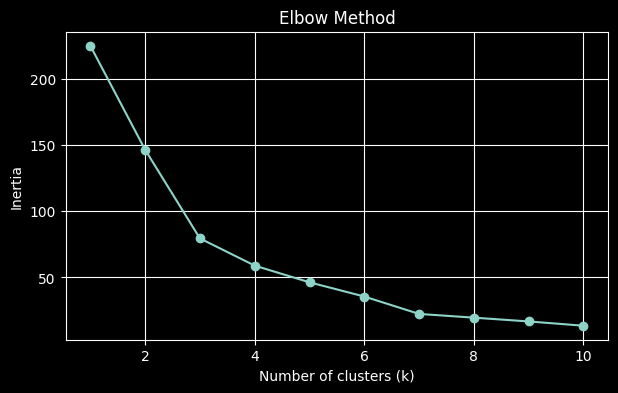

,price_raw_scaled,rating_raw_scaled,distance_minutes_scaled
0,0.318757,0.573273,-0.280701
1,-0.747370,-1.176692,-0.300196
2,0.776488,0.698884,3.309290


In [58]:
# K-Means Clustering for hotel data

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# 1) Select numeric variables

X = df[["price_raw", "rating_raw", "distance_minutes"]].dropna()

# 2) Standardize the data

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3) Elbow method to find optimal k

inertia_values = []
K_range = range(1, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init="auto")
    kmeans.fit(X_scaled)
    inertia_values.append(kmeans.inertia_)

plt.figure(figsize=(7, 4))
plt.plot(K_range, inertia_values, marker='o')
plt.title("Elbow Method")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia")
plt.grid(True)
plt.show()

# 4) Choose k based on elbow plot
# (You will visually decide. Usually k=3 or k=4 works well.)

k_optimal = 3   # <-- change manually depending on your elbow plot

# 5) Train final k-means model

kmeans_final = KMeans(n_clusters=k_optimal, random_state=42, n_init="auto")
kmeans_final.fit(X_scaled)

# 6) Add cluster labels to the dataframe

df["cluster"] = kmeans_final.labels_

# 7) Show cluster centers (in scaled space)

cluster_centers = pd.DataFrame(
    kmeans_final.cluster_centers_,
    columns=["price_raw_scaled", "rating_raw_scaled", "distance_minutes_scaled"]
)

cluster_centers


### Interpretation of the K-Means clustering results

Based on the elbow method, we selected **k = 3 clusters** for the hotel dataset.  
After fitting the k-means model, each hotel was assigned to one of the three clusters.

The cluster centers (in standardized units) indicate the following patterns:

- **Cluster 0 – Low-price / Low-rating / Close-distance hotels**  
  This group represents hotels with relatively low prices and lower ratings, typically located close to the city center.

- **Cluster 1 – High-price / High-rating / Medium-distance hotels**  
  This cluster contains hotels with noticeably higher prices and higher customer ratings.  
  They are usually located slightly further a
